# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



```
# This is formatted as code
```

Let's import necessary libraries

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

Let's get the data!

In [ ]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

In [ ]:
print(type(data))
print(len(data))
print(data[:500])
print("Number of lines:", len(corpus))
print(corpus[:10])  # show first 10 lines

<class 'str'>
95662
	SONNETS



TO THE ONLY BEGETTER OF
THESE INSUING SONNETS
MR. W. H. ALL HAPPINESS
AND THAT ETERNITY
PROMISED BY
OUR EVER-LIVING POET WISHETH
THE WELL-WISHING
ADVENTURER IN
SETTING FORTH
T. T.


I.

FROM fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou, contracted to thine own bright eyes,
Feed'st thy light'st flame with self-substantial fuel,
Making a famine where abundance l
Number of lines: 2634
['\tsonnets', '', '', '', 'to the only begetter of', 'these insuing sonnets', 'mr. w. h. all happiness', 'and that eternity', 'promised by', 'our ever-living poet wisheth']


Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [ ]:
# Your code here :

tokenizer = Tokenizer() # mapping each unique word to an integer

tokenizer.fit_on_texts(corpus) # Keras built a word index (tokenizer.word_index) that maps each unique word to a unique integer.


In [ ]:
print("Total unique words:", len(tokenizer.word_index)) # The tokenizer now has an internal dictionary called word_index

# Print a few word–index pairs
print(list(tokenizer.word_index.items())[:10])


Total unique words: 3374
[('and', 1), ('the', 2), ('to', 3), ('of', 4), ('my', 5), ('i', 6), ('in', 7), ('that', 8), ('thy', 9), ('thou', 10)]


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [ ]:
# Your code here :
# Step 2: Calculate the vocabulary size
total_words = len(tokenizer.word_index) + 1

print("Total words in vocabulary:", total_words)

# Why: The model’s embedding layer needs to know the total number of words.


Total words in vocabulary: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [ ]:
# Your code here :
input_sequences = []

for sentence in corpus:
    token_list = tokenizer.texts_to_sequences([sentence])[0] # Convert the sentence/line to a list of integers

    for i in range(1, len(token_list)): # Generate n-gram sequences
        n_gram_sequence = token_list[:i+1]  # take first i+1 tokens
        input_sequences.append(n_gram_sequence)

print("Number of sequences generated:", len(input_sequences))
print("Example sequence:", input_sequences[0])

# Why: The model learns to predict the next word in a sequence.

Number of sequences generated: 15484
Example sequence: [3, 2]


Calculate the length of the longest sequence in `input_sequences`. Assign the result to a variable called `max_sequence_len`.

Now pad the sequences using `pad_sequences`(`input_sequences, maxlen=max_sequence_len, padding='pre'`).
Convert it to a numpy array and assign the result back to our variable called `input_sequences`.

In [ ]:
# Your code here :
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Step 4: Find the length of the longest sequence
max_sequence_len = max([len(seq) for seq in input_sequences])
print("Maximum sequence length:", max_sequence_len)

input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre') # Pad all sequences to the same length

input_sequences = np.array(input_sequences) # Convert to numpy array (pad_sequences already returns a NumPy array, but just to be safe)

print("Shape of input_sequences after padding:", input_sequences.shape)

# Why: Neural networks need uniform-length inputs.


Maximum sequence length: 11
Shape of input_sequences after padding: (15484, 11)


### Let's visualise whats doen till here!

Original line of text (corpus):  
<span style="color:blue">"from fairest creatures we desire increase"</span>

**Step 1: Tokenize → words to integers**  
<span style="color:green">['from', 'fairest', 'creatures', 'we', 'desire', 'increase']</span>  
<span style="color:red">[15, 234, 76, 12, 98, 321]</span>

**Step 2: Generate n-gram sequences**  
<span style="color:purple">[15, 234]</span>  
<span style="color:purple">[15, 234, 76]</span>  
<span style="color:purple">[15, 234, 76, 12]</span>  
<span style="color:purple">[15, 234, 76, 12, 98]</span>  
<span style="color:purple">[15, 234, 76, 12, 98, 321]</span>

**Step 3: Pad sequences to same length (max_sequence_len=8)**  
<span style="color:orange">[0, 0, 0, 15, 234]</span>  
<span style="color:orange">[0, 0, 15, 234, 76]</span>  
<span style="color:orange">[0, 15, 234, 76, 12]</span>  
<span style="color:orange">[15, 234, 76, 12, 98]</span>  
<span style="color:orange">[0, 0, 15, 234, 76, 12, 98, 321]</span>

**Step 4: Split input & label**  
Input X: <span style="color:green">[0, 0, 15, 234, 76, 12, 98]</span>  
Label y: <span style="color:red">321</span>  (next word)

By Sofia


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [ ]:
# Your code here :
# Split sequences into predictors and labels
X = input_sequences[:, :-1]  # all elements except last
y = input_sequences[:, -1]   # last element

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Example X[0]:", X[0])
print("Example y[0]:", y[0])


Shape of X: (15484, 10)
Shape of y: (15484,)
Example X[0]: [0 0 0 0 0 0 0 0 0 3]
Example y[0]: 2


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [ ]:
print("Number of labels:", len(y))
print("Shape of y:", y.shape)
print("First 10 labels:", y[:10])

Number of labels: 15484
Shape of y: (15484,)
First 10 labels: [   2  313 1375    4 1376  878 1378 1379   23 1380]


In [ ]:
# Your code here :
# One-hot encode the labels
labels = ku.to_categorical(y, num_classes=total_words)

print("Shape of labels:", labels.shape)
print("Example label[0]:", labels[0])


Shape of labels: (15484, 3375)
Example label[0]: [0. 0. 1. ... 0. 0. 0.]


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [ ]:
# built and compiled an LSTM neural network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers

model = Sequential([
    # Embedding layer
    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1),

    # Bidirectional LSTM
    Bidirectional(LSTM(150, return_sequences=True)),

    # Dropout
    Dropout(0.2),

    # Second LSTM
    LSTM(100),

    # Dense layer (intermediate) with L2 regularization
    Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

    # Output layer
    Dense(total_words, activation='softmax')
])

# LSTM Text Generation Model – Step by Step

```python
# 1️⃣ Embedding Layer
Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1)
# Converts word indices into dense 100-dimensional vectors. Each word gets a vector representation.
# input_length=max_sequence_len-1 because input sequence excludes the next word.

# 2️⃣ Bidirectional LSTM
Bidirectional(LSTM(150, return_sequences=True))
# Reads the sequence forward and backward to capture context from both directions.
# return_sequences=True allows stacking another LSTM layer.

# 3️⃣ Dropout
Dropout(0.2)
# Randomly sets 20% of neurons to 0 during training to prevent overfitting.

# 4️⃣ Second LSTM
LSTM(100)
# Processes the output from the previous LSTM and outputs a summary vector for the sequence.

# 5️⃣ Dense Layer (Intermediate)
Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01))
# Fully connected layer with half the vocabulary size as units.
# ReLU activation introduces non-linearity. L2 regularization prevents overfitting.

# 6️⃣ Dense Layer (Output)
Dense(total_words, activation='softmax')
# Produces a probability distribution over all words in the vocabulary.
# The model predicts the next word based on the highest probability.

# 7️⃣ Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Loss: categorical_crossentropy for multi-class word prediction.
# Optimizer: Adam. Metric: accuracy.

By Sofia

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [ ]:
# Your code here :
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_sequence_len-1))


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [ ]:
# Your code here :
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 10, 100)        │       337,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 10, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1687)           │       170,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3375)           │     5,697,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,666,487 (25.43 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [ ]:
# Your code here :
history = model.fit(X, labels, epochs=50, batch_size=128)

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.0222 - loss: 8.0402
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0234 - loss: 6.5295
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0214 - loss: 6.4416
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0277 - loss: 6.3557
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0324 - loss: 6.2707
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0376 - loss: 6.2010
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0403 - loss: 6.1464
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0412 - loss: 6.1110
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0440 - loss: 6.0225
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0507 - loss: 5.9526
Epoch 11/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0496 - loss: 5.8987
Epoch 12/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 

Accuracy started very low (~2%) and slowly improved to ~22% by epoch 50.

Loss steadily decreased from 8.04 → 3.91, meaning the model is learning patterns from the sequences.

This is expected for a text generation model on a large vocabulary like Shakespeare’s sonnets.

### Why 22% isn’t bad here

- Huge vocabulary:

  - Your model predicts one word out of 3,375 possible words.

  - Random chance would be ~0.03% accuracy.

  - So 22% is way above random.

- Sequence prediction is hard:

  - Even a perfect model might not always pick the exact “next word” because multiple words could fit grammatically.

  - Accuracy is strict—only counts exact matches.

- What really matters:

  -Loss decreasing steadily shows the model is learning.

  - Generated text often looks reasonable before accuracy gets very high.

By Sofia

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

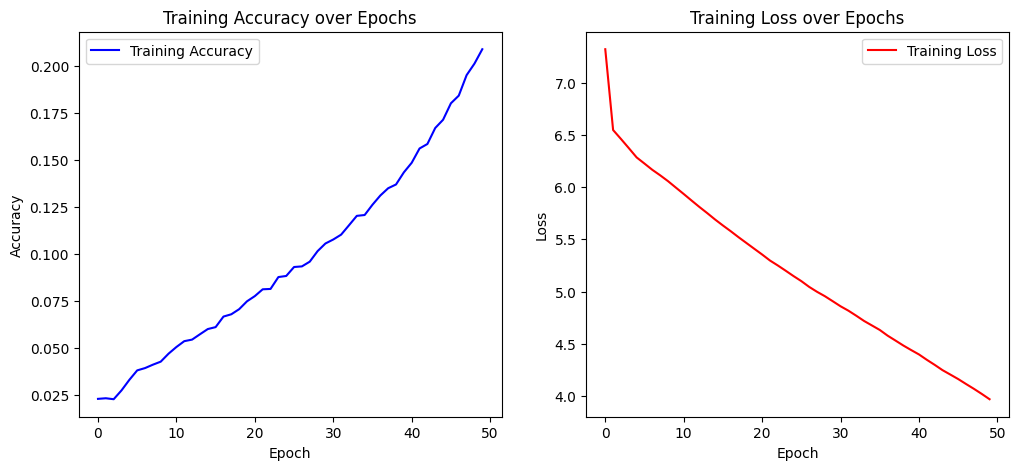

In [ ]:
# Your code here :
import matplotlib.pyplot as plt

# Plot training accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [ ]:
# Your code here :

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [ ]:
# Your code here :

Experiment with at least 3 different seed_text strings and see what happens!

In [ ]:
# Your code here :